In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_curve, auc
)
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import os

In [2]:
DATA_TEST = r"C:\Users\PORTABLE\Desktop\projet_annuel\core\plank_model\data\plank_test_full.csv"
MODEL_PATH = r"C:\Users\PORTABLE\Desktop\projet_annuel\core\plank_model\model\plank_mlp_full.pt"
SCALER_PATH = r"C:\Users\PORTABLE\Desktop\projet_annuel\core\plank_model\model\scaler_full.pkl"

df = pd.read_csv(DATA_TEST)
X = df.drop("label", axis=1).values
y = df["label"].values

with open(SCALER_PATH, "rb") as f:
    scaler = pickle.load(f)

X = scaler.transform(X)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
print("Test dataset:", X.shape, y.shape)

Test dataset: torch.Size([1090, 132]) torch.Size([1090])


In [3]:
class MLP_Full(torch.nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(input_dim,256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(256,128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(128,64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(64,1)
        )
    def forward(self,x):
        return self.net(x)

model = MLP_Full(X.shape[1])
model.load_state_dict(torch.load(MODEL_PATH, map_location="cpu"))
model.eval()


MLP_Full(
  (net): Sequential(
    (0): Linear(in_features=132, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [6]:
with torch.no_grad():
    probs = torch.sigmoid(model(X)).squeeze().numpy()
    preds = (probs > 0.5).astype(int)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc  = accuracy_score(y, preds)
prec = precision_score(y, preds)
rec  = recall_score(y, preds)
f1   = f1_score(y, preds)

print("\n=== METRICS ===")
print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1 Score :", f1)



=== METRICS ===
Accuracy : 0.8018348623853211
Precision: 0.7770700636942676
Recall   : 0.8652482269503546
F1 Score : 0.8187919463087249


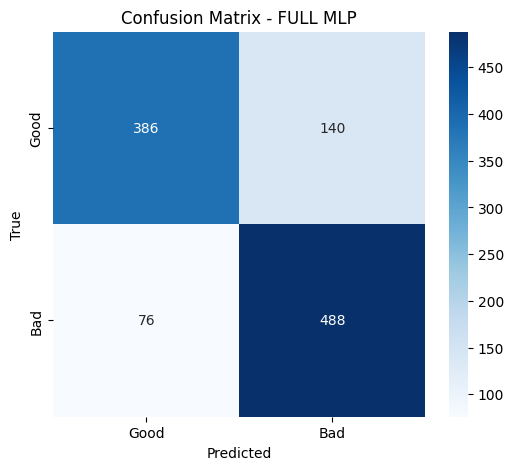

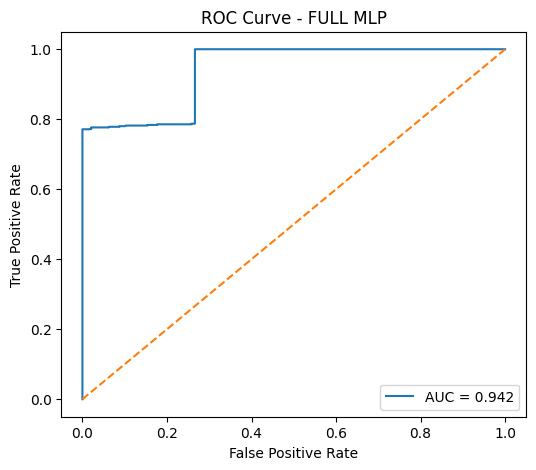

In [7]:
# 5. Confusion Matrix

cm = confusion_matrix(y, preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Good", "Bad"],
            yticklabels=["Good", "Bad"])
plt.title("Confusion Matrix - FULL MLP")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 6. ROC Curve

fpr, tpr, _ = roc_curve(y, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],"--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - FULL MLP")
plt.legend()
plt.show()
